In [787]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,train_test_split,KFold
import lightgbm as lgb
from xgboost import XGBRegressor
from rfpimp import *
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
import numpy as np
pd.set_option('display.max_columns', None)

In [788]:
df_train = pd.read_csv("loans_train_data.csv")
df_test = pd.read_csv("loans_test_data.csv")

<AxesSubplot:>

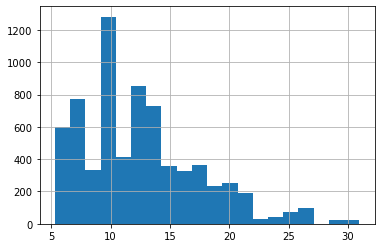

In [789]:
df_train['interest_rate'].hist(bins=20)

In [790]:
df_train

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,initial_listing_status,disbursement_method,id
0,instructor,2.0,NY,RENT,45000.0,Source Verified,6.71,NaN,NaN,NaN,0,NaN,2011,0,5,4,9300,7743,0,0,NaN,0,0,0,0,NaN,4,0.0,0,3,7600,5,4,4,0,100.0,0,0,debt_consolidation,individual,12000,60,19.03,whole,Cash,1
1,owner,10.0,CA,RENT,68000.0,Source Verified,18.99,NaN,NaN,NaN,0,NaN,1971,1,14,5,44050,34712,0,1,NaN,0,0,2,3,3.0,5,0.0,0,2,16000,10,3,2,1,100.0,0,1,small_business,individual,7200,36,16.01,whole,Cash,2
2,merchandiser,10.0,TN,OWN,15000.0,Source Verified,20.83,NaN,NaN,NaN,0,NaN,2007,1,9,5,19300,6502,0,0,NaN,0,0,0,1,1.0,5,0.0,0,4,19300,7,5,4,0,100.0,0,0,credit_card,individual,5000,36,11.99,whole,Cash,3
3,deputy clerk,2.0,OH,MORTGAGE,35000.0,Verified,35.56,NaN,NaN,NaN,0,29.0,2007,3,16,8,76236,36051,1,0,NaN,0,239,3,1,0.0,8,0.0,0,2,8000,6,4,3,1,93.8,0,0,debt_consolidation,individual,12800,60,23.88,whole,DirectPay,4
4,teacher,2.0,UT,RENT,34000.0,Not Verified,13.20,NaN,NaN,NaN,0,NaN,2011,0,8,8,20577,18633,0,0,NaN,0,0,6,3,21.0,8,0.0,0,1,1000,2,2,2,0,100.0,0,0,credit_card,individual,1200,36,10.90,whole,Cash,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,human capital consultant,1.0,VA,MORTGAGE,115000.0,Not Verified,22.79,NaN,NaN,NaN,0,NaN,1994,1,34,11,120600,64800,0,0,NaN,0,0,2,5,10.0,11,0.0,0,1,38200,17,7,2,3,100.0,0,0,credit_card,individual,20000,36,7.34,whole,Cash,6996
6996,director of property operations,3.0,CA,RENT,116480.0,Verified,13.74,NaN,NaN,NaN,0,NaN,1999,1,10,8,594367,59440,0,0,NaN,0,0,1,3,2.0,8,0.0,0,5,45200,7,6,6,2,100.0,0,0,credit_card,individual,10000,36,10.42,whole,Cash,6997
6997,rn,9.0,CA,RENT,200000.0,Source Verified,8.38,NaN,NaN,NaN,1,11.0,1996,0,32,7,61965,54789,0,0,11.0,0,0,3,0,NaN,7,0.0,0,4,9900,16,4,4,0,65.6,0,0,credit_card,individual,16000,36,9.93,whole,Cash,6998
6998,attorney - member,8.0,VT,MORTGAGE,350000.0,Source Verified,11.98,NaN,NaN,NaN,0,NaN,1993,2,23,11,680784,162278,0,0,NaN,0,0,3,4,10.0,11,0.0,0,5,91000,9,6,5,4,100.0,0,0,credit_card,individual,15000,36,12.61,whole,Cash,6999


In [791]:
df_train.isnull().sum()/len(df_train)

emp_title                           0.081286
emp_length                          0.079571
state                               0.000000
homeownership                       0.000000
annual_income                       0.000000
verified_income                     0.000000
debt_to_income                      0.002000
annual_income_joint                 0.848714
verification_income_joint           0.852286
debt_to_income_joint                0.848714
delinq_2y                           0.000000
months_since_last_delinq            0.562857
earliest_credit_line                0.000000
inquiries_last_12m                  0.000000
total_credit_lines                  0.000000
open_credit_lines                   0.000000
total_credit_limit                  0.000000
total_credit_utilized               0.000000
num_collections_last_12m            0.000000
num_historical_failed_to_pay        0.000000
months_since_90d_late               0.769857
current_accounts_delinq             0.000000
total_coll

In [792]:
df_train.nunique()

emp_title                           3535
emp_length                            11
state                                 50
homeownership                          3
annual_income                       1100
verified_income                        3
debt_to_income                      3237
annual_income_joint                  470
verification_income_joint              3
debt_to_income_joint                 899
delinq_2y                             11
months_since_last_delinq              95
earliest_credit_line                  53
inquiries_last_12m                    24
total_credit_lines                    78
open_credit_lines                     43
total_credit_limit                  6508
total_credit_utilized               6751
num_collections_last_12m               4
num_historical_failed_to_pay           8
months_since_90d_late                101
current_accounts_delinq                2
total_collection_amount_ever         698
current_installment_accounts          28
accounts_opened_

In [793]:
cols_rm = []
for i in df_train.columns:
    if df_train[i].nunique() == 1 or df_train[i].nunique() == len(df_train):
        cols_rm.append(i)

In [794]:
df_train['state'].dtype == 'O'

True

In [795]:
from matplotlib_venn import venn2, venn2_circles

In [796]:
cols_obj = []
for i in df_train.columns:
    if df_train[i].dtype == 'O':
        cols_obj.append(i)

In [797]:
cols_obj

['emp_title',
 'state',
 'homeownership',
 'verified_income',
 'verification_income_joint',
 'loan_purpose',
 'application_type',
 'initial_listing_status',
 'disbursement_method']

In [798]:
df_train
#create a feature with a monthly payments and loan amount

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,initial_listing_status,disbursement_method,id
0,instructor,2.0,NY,RENT,45000.0,Source Verified,6.71,NaN,NaN,NaN,0,NaN,2011,0,5,4,9300,7743,0,0,NaN,0,0,0,0,NaN,4,0.0,0,3,7600,5,4,4,0,100.0,0,0,debt_consolidation,individual,12000,60,19.03,whole,Cash,1
1,owner,10.0,CA,RENT,68000.0,Source Verified,18.99,NaN,NaN,NaN,0,NaN,1971,1,14,5,44050,34712,0,1,NaN,0,0,2,3,3.0,5,0.0,0,2,16000,10,3,2,1,100.0,0,1,small_business,individual,7200,36,16.01,whole,Cash,2
2,merchandiser,10.0,TN,OWN,15000.0,Source Verified,20.83,NaN,NaN,NaN,0,NaN,2007,1,9,5,19300,6502,0,0,NaN,0,0,0,1,1.0,5,0.0,0,4,19300,7,5,4,0,100.0,0,0,credit_card,individual,5000,36,11.99,whole,Cash,3
3,deputy clerk,2.0,OH,MORTGAGE,35000.0,Verified,35.56,NaN,NaN,NaN,0,29.0,2007,3,16,8,76236,36051,1,0,NaN,0,239,3,1,0.0,8,0.0,0,2,8000,6,4,3,1,93.8,0,0,debt_consolidation,individual,12800,60,23.88,whole,DirectPay,4
4,teacher,2.0,UT,RENT,34000.0,Not Verified,13.20,NaN,NaN,NaN,0,NaN,2011,0,8,8,20577,18633,0,0,NaN,0,0,6,3,21.0,8,0.0,0,1,1000,2,2,2,0,100.0,0,0,credit_card,individual,1200,36,10.90,whole,Cash,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,human capital consultant,1.0,VA,MORTGAGE,115000.0,Not Verified,22.79,NaN,NaN,NaN,0,NaN,1994,1,34,11,120600,64800,0,0,NaN,0,0,2,5,10.0,11,0.0,0,1,38200,17,7,2,3,100.0,0,0,credit_card,individual,20000,36,7.34,whole,Cash,6996
6996,director of property operations,3.0,CA,RENT,116480.0,Verified,13.74,NaN,NaN,NaN,0,NaN,1999,1,10,8,594367,59440,0,0,NaN,0,0,1,3,2.0,8,0.0,0,5,45200,7,6,6,2,100.0,0,0,credit_card,individual,10000,36,10.42,whole,Cash,6997
6997,rn,9.0,CA,RENT,200000.0,Source Verified,8.38,NaN,NaN,NaN,1,11.0,1996,0,32,7,61965,54789,0,0,11.0,0,0,3,0,NaN,7,0.0,0,4,9900,16,4,4,0,65.6,0,0,credit_card,individual,16000,36,9.93,whole,Cash,6998
6998,attorney - member,8.0,VT,MORTGAGE,350000.0,Source Verified,11.98,NaN,NaN,NaN,0,NaN,1993,2,23,11,680784,162278,0,0,NaN,0,0,3,4,10.0,11,0.0,0,5,91000,9,6,5,4,100.0,0,0,credit_card,individual,15000,36,12.61,whole,Cash,6999


In [799]:
df_train['avg_income_emp_len'] = df_train['annual_income']/df_train['emp_length']
df_train['avg_income_joint_emp_len'] = df_train['annual_income_joint']/df_train['emp_length']
df_train['Debt'] = df_train['debt_to_income']*df_train['annual_income']
df_train['Debt_joint'] = df_train['debt_to_income']*df_train['annual_income_joint']
df_train['years_since_credit_line'] = 2022 - df_train['earliest_credit_line']
df_train['credit_lines_remaining'] = df_train['total_credit_lines'] - df_train['open_credit_lines']
df_train['credit_left'] = df_train['total_credit_limit'] - df_train['total_credit_utilized']
df_train['credit_left_bool'] = np.where(df_train['credit_left'] < 0,1,0)
df_train['percent_credit_income'] = df_train['annual_income']/df_train['loan_amount']
df_train['percent_credit_income_joint'] = df_train['annual_income_joint']/df_train['loan_amount']
df_train['total_money_after_loan_approved'] = df_train['credit_left']+df_train['loan_amount']
df_train['debt_after_loan'] = df_train['total_money_after_loan_approved']/df_train['annual_income']
df_train['debt_after_loan_joint'] = df_train['total_money_after_loan_approved']/df_train['annual_income_joint']
df_train['debit_to_credit_ratio'] = df_train['total_debit_limit']/df_train['total_credit_limit']
df_train['total_income_debit_limit'] = df_train['total_debit_limit']/df_train['annual_income']
df_train['total_income_joint_debit_limit'] = df_train['total_debit_limit']/df_train['annual_income_joint']

In [800]:
df_test['avg_income_emp_len'] = df_test['annual_income']/df_test['emp_length']
df_test['avg_income_joint_emp_len'] = df_test['annual_income_joint']/df_test['emp_length']
df_test['Debt'] = df_test['debt_to_income']*df_test['annual_income']
df_test['Debt_joint'] = df_test['debt_to_income']*df_test['annual_income_joint']
df_test['years_since_credit_line'] = 2022 - df_test['earliest_credit_line']
df_test['credit_lines_remaining'] = df_test['total_credit_lines'] - df_test['open_credit_lines']
df_test['credit_left'] = df_test['total_credit_limit'] - df_test['total_credit_utilized']
df_test['credit_left_bool'] = np.where(df_test['credit_left'] < 0,1,0)
df_test['percent_credit_income'] = df_test['annual_income']/df_test['loan_amount']
df_test['percent_credit_income_joint'] = df_test['annual_income_joint']/df_test['loan_amount']
df_test['total_money_after_loan_approved'] = df_test['credit_left']+df_test['loan_amount']
df_test['debt_after_loan'] = df_test['total_money_after_loan_approved']/df_test['annual_income']
df_test['debt_after_loan_joint'] = df_test['total_money_after_loan_approved']/df_test['annual_income_joint']
df_test['debit_to_credit_ratio'] = df_test['total_debit_limit']/df_test['total_credit_limit']
df_test['total_income_debit_limit'] = df_test['total_debit_limit']/df_test['annual_income']
df_test['total_income_joint_debit_limit'] = df_test['total_debit_limit']/df_test['annual_income_joint']

In [801]:
df_train['months_since_last_credit_inquiry'].fillna(0,inplace=True)
df_train['months_since_90d_late'].fillna(0,inplace=True)
df_train['months_since_last_delinq'].fillna(0,inplace=True)

df_test['months_since_last_credit_inquiry'].fillna(0,inplace=True)
df_test['months_since_90d_late'].fillna(0,inplace=True)
df_test['months_since_last_delinq'].fillna(0,inplace=True)

In [802]:
vals

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Text(0.5, 1.0, 'emp_title')

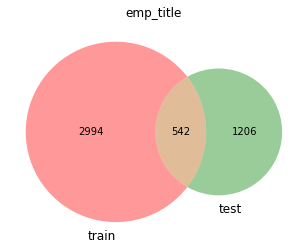

In [803]:
venn2([set(df_train['emp_title'].values), set(df_test['emp_title'].values)], set_labels = ('train','test'))
plt.title('emp_title')

Text(0.5, 1.0, 'state')

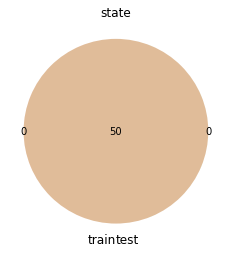

In [804]:
venn2([set(df_train['state'].values), set(df_test['state'].values)], set_labels = ('train','test'))
plt.title('state')

Text(0.5, 1.0, 'homeownership')

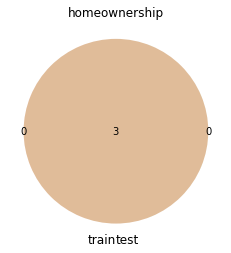

In [805]:
venn2([set(df_train['homeownership'].values), set(df_test['homeownership'].values)], set_labels = ('train','test'))
plt.title('homeownership')

Text(0.5, 1.0, 'verification_income_joint')

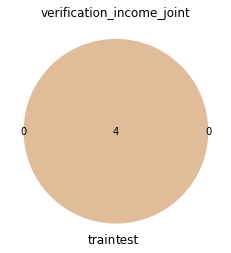

In [806]:
venn2([set(df_train['verification_income_joint'].values), set(df_test['verification_income_joint'].values)], set_labels = ('train','test'))
plt.title('verification_income_joint')

Text(0.5, 1.0, 'verified_income')

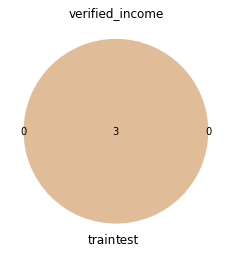

In [807]:
venn2([set(df_train['verified_income'].values), set(df_test['verified_income'].values)], set_labels = ('train','test'))
plt.title('verified_income')

Text(0.5, 1.0, 'loan_purp')

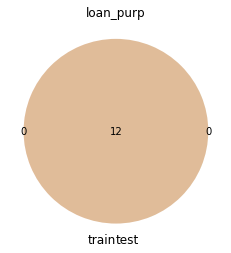

In [808]:
venn2([set(df_train['loan_purpose'].values), set(df_test['loan_purpose'].values)], set_labels = ('train','test'))
plt.title('loan_purp')

Text(0.5, 1.0, 'application_type')

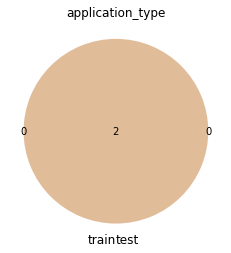

In [809]:
venn2([set(df_train['application_type'].values), set(df_test['application_type'].values)], set_labels = ('train','test'))
plt.title('application_type')

Text(0.5, 1.0, 'initial_listing_status')

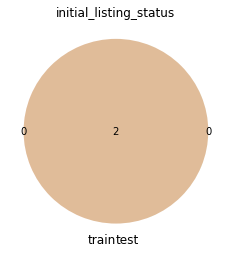

In [810]:
venn2([set(df_train['initial_listing_status'].values), set(df_test['initial_listing_status'].values)], set_labels = ('train','test'))
plt.title('initial_listing_status')

Text(0.5, 1.0, 'disbursment_method')

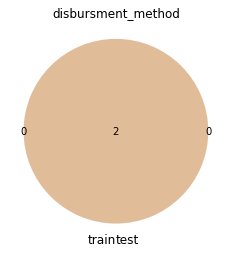

In [811]:
venn2([set(df_train['disbursement_method'].values), set(df_test['disbursement_method'].values)], set_labels = ('train','test'))
plt.title('disbursment_method')

In [812]:
cols_obj.remove('emp_title')

In [813]:
for i in df_train[cols_obj].columns:
    lb = LabelEncoder()
    lb.fit(df_train[i])
    df_train[i] = lb.transform(df_train[i])
    df_test[i] = lb.transform(df_test[i])

In [814]:
df_train

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,initial_listing_status,disbursement_method,id,avg_income_emp_len,avg_income_joint_emp_len,Debt,Debt_joint,years_since_credit_line,credit_lines_remaining,credit_left,credit_left_bool,percent_credit_income,percent_credit_income_joint,total_money_after_loan_approved,debt_after_loan,debt_after_loan_joint,debit_to_credit_ratio,total_income_debit_limit,total_income_joint_debit_limit,avg_money_to_pay_monthly
0,instructor,2.0,33,2,45000.0,1,6.71,NaN,3,NaN,0,0.0,2011,0,5,4,9300,7743,0,0,0.0,0,0,0,0,0.0,4,0.0,0,3,7600,5,4,4,0,100.0,0,0,2,0,12000,60,19.03,1,0,1,22500.000000,NaN,301950.0,NaN,11,1,1557,0,3.750000,NaN,13557,0.301267,NaN,0.817204,0.168889,NaN,2.248000e+05
1,owner,10.0,4,2,68000.0,1,18.99,NaN,3,NaN,0,0.0,1971,1,14,5,44050,34712,0,1,0.0,0,0,2,3,3.0,5,0.0,0,2,16000,10,3,2,1,100.0,0,1,10,0,7200,36,16.01,1,0,2,6800.000000,NaN,1291320.0,NaN,51,9,9338,0,9.444444,NaN,16538,0.243206,NaN,0.363224,0.235294,NaN,2.038000e+05
2,merchandiser,10.0,41,1,15000.0,1,20.83,NaN,3,NaN,0,0.0,2007,1,9,5,19300,6502,0,0,0.0,0,0,0,1,1.0,5,0.0,0,4,19300,7,5,4,0,100.0,0,0,1,0,5000,36,11.99,1,0,3,1500.000000,NaN,312450.0,NaN,15,4,12798,0,3.000000,NaN,17798,1.186533,NaN,1.000000,1.286667,NaN,4.486111e+04
3,deputy clerk,2.0,34,0,35000.0,2,35.56,NaN,3,NaN,0,29.0,2007,3,16,8,76236,36051,1,0,0.0,0,239,3,1,0.0,8,0.0,0,2,8000,6,4,3,1,93.8,0,0,2,0,12800,60,23.88,1,1,4,17500.000000,NaN,1244600.0,NaN,15,8,40185,0,2.734375,NaN,52985,1.513857,NaN,0.104937,0.228571,NaN,1.747867e+05
4,teacher,2.0,43,2,34000.0,0,13.20,NaN,3,NaN,0,0.0,2011,0,8,8,20577,18633,0,0,0.0,0,0,6,3,21.0,8,0.0,0,1,1000,2,2,2,0,100.0,0,0,1,0,1200,36,10.90,1,0,5,17000.000000,NaN,448800.0,NaN,11,0,1944,0,28.333333,NaN,3144,0.092471,NaN,0.048598,0.029412,NaN,1.019667e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,human capital consultant,1.0,44,0,115000.0,0,22.79,NaN,3,NaN,0,0.0,1994,1,34,11,120600,64800,0,0,0.0,0,0,2,5,10.0,11,0.0,0,1,38200,17,7,2,3,100.0,0,0,1,0,20000,36,7.34,1,0,6996,115000.000000,NaN,2620850.0,NaN,28,23,55800,0,5.750000,NaN,75800,0.659130,NaN,0.316750,0.332174,NaN,3.444444e+05
6996,director of property operations,3.0,4,2,116480.0,2,13.74,NaN,3,NaN,0,0.0,1999,1,10,8,594367,59440,0,0,0.0,0,0,1,3,2.0,8,0.0,0,5,45200,7,6,6,2,100.0,0,0,1,0,10000,36,10.42,1,0,6997,38826.666667,NaN,1600435.2,NaN,23,2,534927,0,11.648000,NaN,544927,4.678288,NaN,0.076047,0.388049,NaN,3.491622e+05
6997,rn,9.0,4,2,200000.0,1,8.38,NaN,3,NaN,1,11.0,1996,0,32,7,61965,54789,0,0,11.0,0,0,3,0,0.0,7,0.0,0,4,9900,16,4,4,0,65.6,0,0,1,0,16000,36,9.93,1,0,6998,22222.222222,NaN,1676000.0,NaN,26,25,7176,0,12.500000,NaN,23176,0.115880,NaN,0.159768,0.049500,NaN,5.995556e+05
6998,attorney - member,8.0,45,0,350000.0,1,11.98,NaN,3,NaN,0,0.0,1993,2,23,11,680784,162278,0,0,0.0,0,0,3,4,10.0,11,0.0,0,5,91000,9,6,5,4,100.0,0,0,1,0,15000,36,12.61,1,0,6999,43750.000000,NaN,4193000.0,NaN,29,12,518506,0,23.333333,NaN,533506,1.524303,NaN,0.133669,0.260000,NaN,1.049583e+06


In [815]:
def corrleation(dataset,threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]>=threshold) and (corr_matrix.columns[j] not in col_corr):
                print(corr_matrix.columns[i],corr_matrix.columns[j])
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(colname)

In [816]:
corrleation(df_train,threshold=0.45)

annual_income_joint annual_income
annual_income_joint
open_credit_lines total_credit_lines
open_credit_lines
total_credit_limit annual_income
total_credit_limit
total_credit_utilized total_credit_lines
total_credit_utilized
months_since_90d_late months_since_last_delinq
months_since_90d_late
num_satisfactory_accounts total_credit_lines
num_satisfactory_accounts
num_satisfactory_accounts current_installment_accounts
num_satisfactory_accounts
num_satisfactory_accounts accounts_opened_24m
num_satisfactory_accounts
num_accounts_30d_past_due current_accounts_delinq
num_accounts_30d_past_due
total_debit_limit num_active_debit_accounts
total_debit_limit
num_total_cc_accounts total_credit_lines
num_total_cc_accounts
num_total_cc_accounts num_active_debit_accounts
num_total_cc_accounts
num_open_cc_accounts total_credit_lines
num_open_cc_accounts
num_open_cc_accounts accounts_opened_24m
num_open_cc_accounts
num_open_cc_accounts num_active_debit_accounts
num_open_cc_accounts
num_cc_carrying_balan

In [817]:
cols_rm = ['num_satisfactory_accounts','num_accounts_30d_past_due','num_accounts_120d_past_due','emp_title']
df_train.drop(cols_rm,inplace=True,axis=1)
df_test.drop(cols_rm,inplace=True,axis=1)

In [818]:
df_train = pd.get_dummies(df_train,columns=['loan_purpose','homeownership','verification_income_joint','verified_income'])
df_test = pd.get_dummies(df_test,columns=['loan_purpose','homeownership','verification_income_joint','verified_income'])

In [819]:
df_test.shape

(3000, 76)

In [820]:
df_train['interest_rate'] = np.log1p(df_train['interest_rate'])

In [821]:
# Creating and holdout set and train 
X_train,X_valid,y_train,y_valid = train_test_split(df_train.drop(['interest_rate','id'],axis=1),df_train['interest_rate'],random_state=22,test_size=0.29)

In [822]:
# emp_1_enc = (X_train.groupby("emp_title").size())/len(X_train)
# X_train['emp_title_freq'] = X_train['emp_title'].apply(lambda x: emp_1_enc[x])

# emp_1_enc = (X_valid.groupby("emp_title").size())/len(X_valid)
# X_valid['emp_title_freq'] = X_valid['emp_title'].apply(lambda x: emp_1_enc[x])

# emp_1_enc = (df_test.groupby("emp_title").size())/len(df_test)
# df_test['emp_title_freq'] = df_test['emp_title'].apply(lambda x: emp_1_enc[x])





In [823]:
df_test

,emp_length,state,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,application_type,loan_amount,term,initial_listing_status,disbursement_method,id,avg_income_emp_len,avg_income_joint_emp_len,Debt,Debt_joint,years_since_credit_line,credit_lines_remaining,credit_left,credit_left_bool,percent_credit_income,percent_credit_income_joint,total_money_after_loan_approved,debt_after_loan,debt_after_loan_joint,debit_to_credit_ratio,total_income_debit_limit,total_income_joint_debit_limit,avg_money_to_pay_monthly,loan_purpose_0,loan_purpose_1,loan_purpose_2,loan_purpose_3,loan_purpose_4,loan_purpose_5,loan_purpose_6,loan_purpose_7,loan_purpose_8,loan_purpose_9,loan_purpose_10,loan_purpose_11,homeownership_0,homeownership_1,homeownership_2,verification_income_joint_0,verification_income_joint_1,verification_income_joint_2,verification_income_joint_3,verified_income_0,verified_income_1,verified_income_2
0,2.0,13,75000.0,26.19,NaN,NaN,0,25.0,1986,1,21,11,280228,62194,0,0,0.0,0,0,5,2,1.0,4,48000,8,5,5,2,95.2,0,0,0,20000,60,1,0,7001,37500.000000,NaN,1964250.00,NaN,36,10,218034,0,3.750000,NaN,238034,3.173787,NaN,0.171289,0.640000,NaN,374666.666667,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,5.0,30,28000.0,21.86,NaN,NaN,0,0.0,2004,1,10,2,2200,1495,0,0,0.0,0,0,0,2,5.0,1,1000,7,2,2,0,100.0,0,0,0,2000,36,1,0,7002,5600.000000,NaN,612080.00,NaN,18,8,705,0,14.000000,NaN,2705,0.096607,NaN,0.454545,0.035714,NaN,83944.444444,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,2.0,17,25992.0,9.25,NaN,NaN,1,7.0,1995,1,9,6,50300,6968,0,0,0.0,0,0,0,2,10.0,3,36000,7,6,4,0,88.9,0,0,0,12000,36,1,0,7003,12996.000000,NaN,240426.00,NaN,27,3,43332,0,2.166000,NaN,55332,2.128809,NaN,0.715706,1.385042,NaN,77642.666667,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3,NaN,32,33000.0,3.89,NaN,NaN,0,0.0,1998,3,47,23,30100,3906,0,1,0.0,0,0,0,10,8.0,2,16800,45,23,4,1,100.0,0,1,0,5000,36,0,0,7004,NaN,NaN,128370.00,NaN,24,24,26194,0,6.600000,NaN,31194,0.945273,NaN,0.558140,0.509091,NaN,98861.111111,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,10.0,1,47000.0,15.82,NaN,NaN,0,71.0,1996,0,18,4,27979,24400,0,0,71.0,0,0,1,2,0.0,2,10700,7,3,3,0,94.4,0,0,0,2000,36,0,0,7005,4700.000000,NaN,743540.00,NaN,26,14,3579,0,23.500000,NaN,5579,0.118702,NaN,0.382430,0.227660,NaN,140944.444444,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4.0,13,21600.0,25.50,NaN,NaN,0,0.0,1998,4,33,9,30292,22928,0,1,0.0,0,110,1,4,4.0,1,1000,16,8,3,0,100.0,0,1,0,10000,36,1,0,9996,5400.000000,NaN,550800.00,NaN,24,24,7364,0,2.160000,NaN,17364,0.803889,NaN,0.033012,0.046296,NaN,64522.222222,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
2996,3.0,34,38000.0,10.14,NaN,NaN,0,0.0,2005,4,12,9,39300,21343,0,1,0.0,0,0,1,4,5.0,0,14400,9,8,0,1,100.0,0,1,0,3000,36,1,0,9997,12666.666667,NaN,385320.00,NaN,17,3,17957,0,12.666667,NaN,20957,0.551500,NaN,0.366412,0.378947,NaN,113916.666667,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
2997,1.0,46,60000.0,2.84,NaN,NaN,0,0.0,2008,0,4,3,15200,4102,0,0,0.0,0,0,0,2,13.0,2,12500,3,3,2,0,100.0,0,0,0,6000,36,0,0,9998,60000.000000,NaN,170400.00,NaN,14,1,11098,0,10.000000,NaN,17098,0.284967,NaN,0.822368,0.208333,NaN,179833.333333,0,

In [824]:
splits = 7
folds = KFold(n_splits=splits, shuffle=True, random_state=22)
valid_preds = np.zeros((len(X_valid), 1))
test_preds = np.zeros((len(df_test), 1))
feature_importance_df = pd.DataFrame()
oof_preds = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train.iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train.iloc[val_idx],y_train.iloc[val_idx]
        clf  = lgb.LGBMRegressor(random_state=22,n_jobs=-1,n_estimators=2000)
        clf.fit(X_trn, y_trn, eval_metric="regression", eval_set=[(X_val,y_val)], verbose=False,early_stopping_rounds=100)
        print(sqrt(mean_squared_error(y_pred=clf.predict(X_val),y_true=y_val)))
        oof_preds.append(sqrt(mean_squared_error(y_pred=clf.predict(X_val),y_true=y_val)))
        valid_preds += clf.predict(X_valid).reshape(-1,1)
        test_preds += clf.predict(df_test.drop('id',axis=1)).reshape(-1,1)
    
        
test_preds = test_preds/splits
valid_preds = valid_preds/splits

print(f"The cross validation score is : {sum(oof_preds)/splits}")
print(f"The validation score is : {sqrt(mean_squared_error(y_pred=valid_preds,y_true=y_valid))}")

Fold 0


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.2471677594292296
Fold 1


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.2575364204276133
Fold 2


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.2549788912664909
Fold 3


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.25988816848823154
Fold 4


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.2596884534008234
Fold 5


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.25983887887217466
Fold 6


C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kjuneja\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.26031427810800456
The cross validation score is : 0.25705897857036686
The validation score is : 0.252853206885984


In [825]:
new_score=0.256123
new_score_feats = 0.25607

In [826]:
# clf = lgb.LGBMRegressor(n_estimators=100,random_state=22)
# clf.fit(X_train,y_train)
# preds = clf.predict(X_valid)


In [827]:
df_test['preds'] = test_preds

In [828]:
df_test['preds'] = np.expm1(df_test['preds'])

<AxesSubplot:>

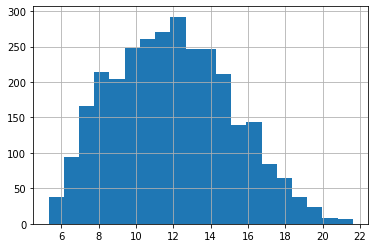

In [829]:
df_test['preds'].hist(bins=20)

In [830]:
df_sub = df_test[['id','preds']]

In [831]:
df_sub.rename(columns={'preds':'interest_rate'},inplace=True)

C:\Users\kjuneja\AppData\Local\Temp\ipykernel_5228\2992055295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.rename(columns={'preds':'interest_rate'},inplace=True)


In [832]:
df_sub.to_csv('basic_feats_rmsle_0.25178_valid_0.2560_cval_7folds.csv',index=False)